In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

Read image

In [11]:
image_front = cv.imread('/content/Pic1.jpg')
image_front = cv.cvtColor(image_front, cv.COLOR_BGR2RGB)

In [13]:
height_front, width_front, _ = image_front.shape

In [15]:
input_front_image = image_front.copy()

Model set

In [17]:
model_path_posenet = "/content/posenet_mv1_075_float_from_checkpoints.tflite" #337x337 input shape

In [18]:
interpreter = tf.lite.Interpreter(model_path=model_path_posenet)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [19]:
input_details

[{'dtype': numpy.float32,
  'index': 92,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 337, 337,   3], dtype=int32),
  'shape_signature': array([  1, 337, 337,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [21]:
# preprocessing 
input_front_image = cv.resize(image_front.copy(), (337, 337))

height_front_coef = height_front / 337
width_front_coef = width_front / 337

front_ratio = [height_front_coef, width_front_coef]

input_front_image = np.expand_dims(input_front_image, axis=0)
input_front_image = (np.float32(input_front_image) - 127.5) / 127.5

In [22]:
# inference 
interpreter.set_tensor(input_details[0]['index'], input_front_image) 
interpreter.invoke()

front_output_data = interpreter.get_tensor(output_details[0]['index']) # heatmaps
front_offset_data = interpreter.get_tensor(output_details[1]['index']) # offsets

front_heatmaps = np.squeeze(front_output_data)
front_offsets = np.squeeze(front_offset_data)

In [24]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [25]:
#337х337
def parse_output(heatmap_data,offset_data, threshold): #функция для получение координат точек 

  '''
  Input:
    heatmap_data - hetmaps for an image. Three dimension array
    offset_data - offset vectors for an image. Three dimension array
    threshold - probability threshold for the keypoints. Scalar value
  Output:
    array with coordinates of the keypoints and flags for those that have
    low probability
  '''
  joint_num = heatmap_data.shape[-1] #количество точек=кол-ву каналов хитмапс (17)
  pose_kps = np.zeros((joint_num,3), np.uint32) #получаем матрицу,заполненную нулями размера 17х3
  confidence_scores = np.array([])
  for i in range(heatmap_data.shape[-1]):

      joint_heatmap = heatmap_data[...,i]
      #здесь np.max ищем максимальное значение хитмапа, и np.argwhere получаем его координату, np.squeeze удаляем лишнюю ось
      max_val_pos = np.squeeze(np.argwhere(joint_heatmap == np.max(joint_heatmap)))
      remap_pos = np.array(max_val_pos/21*337,dtype=np.int32) #возвращаем к подходящему размеру
      pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
      pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i + joint_num])
      max_prob = np.max(joint_heatmap)
      max_prob = sigmoid(max_prob)
      confidence_scores = np.append(confidence_scores, max_prob) #из значения в [0,1]

      if max_prob > threshold: #сравниваем это значение с пороговым
        if pose_kps[i,0] < 337 and pose_kps[i,1] < 337:
          pose_kps[i,2] = 1
        else:
          pose_kps[i,0]=0
          pose_kps[i,1]=0
      else:
        pose_kps[i,0]=0
        pose_kps[i,1]=0
  return pose_kps, confidence_scores

In [26]:
front_peacks, scores = parse_output(front_heatmaps, front_offsets, 0.2)

In [28]:
scores # confidence scores of each key points 0-17

array([0.99978045, 0.99950755, 0.99946221, 0.97901798, 0.91934467,
       0.99847277, 0.99059529, 0.96926163, 0.91283673, 0.90216145,
       0.74649453, 0.98814928, 0.98746489, 0.98898614, 0.90481464,
       0.85297029, 0.80504555])

In [29]:
# The lowest confidence point
print(f'Point № {np.argmin(scores)}, with confidence score = {np.min(scores)}')
print(f'Mean confidence score for all points = {np.mean(scores)}')

Point № 10, with confidence score = 0.7464945309312035
Mean confidence score for all points = 0.9379038865043428


In [30]:
front_resized_peacks=np.zeros((17,3),dtype='uint32') #возвращение точек к оригинальному масштабу 
for i in range(len(front_peacks)):
  front_resized_peacks[i,0]= int(front_peacks[i][1] * front_ratio[1])
  front_resized_peacks[i,1]= int(front_peacks[i][0] * front_ratio[0])
  front_resized_peacks[i,2]= front_peacks[i][2] 

In [32]:
pair_points = ((5, 6), (5, 7), (6, 8), (7, 9), (8, 10), (5, 11), (6, 12), (11, 12), (11, 13), (12, 14), (13, 15), (14, 16))

In [33]:
for pair in pair_points:
  p_1 = pair[0]
  p_2 = pair[1]
  cv.line(image_front, (front_resized_peacks[p_1][0], front_resized_peacks[p_1][1]), 
          (front_resized_peacks[p_2][0], front_resized_peacks[p_2][1]), [0,255,255], 6)

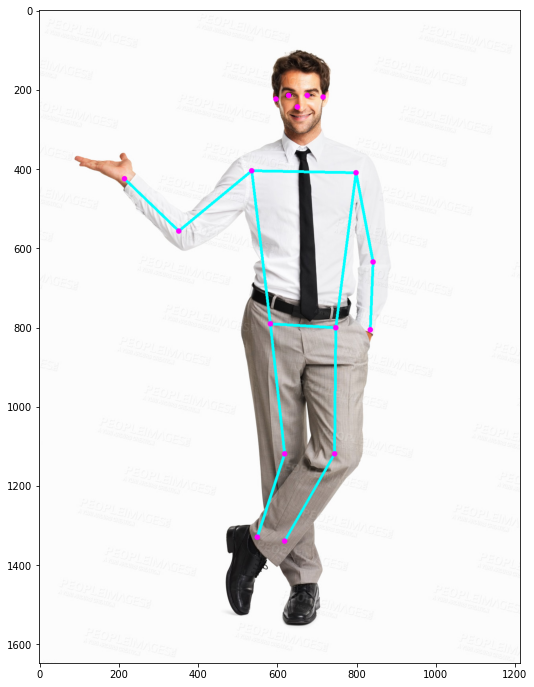

In [34]:
import matplotlib
for peack in front_peacks:
  cv.circle(image_front,(int(peack[1] * front_ratio[1]),int(peack[0]*front_ratio[0])),7,[255,0,255],-1)
plt.imshow(image_front)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)